In [2]:
!pip install bert-for-tf2

  Stored in directory: C:\Users\Shintaki\AppData\Local\pip\Cache\wheels\dd\f1\10\861fd7899727e4034293fb1dfef45b00f8cd476d21d3b3821e
  Stored in directory: C:\Users\Shintaki\AppData\Local\pip\Cache\wheels\67\f5\19\b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Stored in directory: C:\Users\Shintaki\AppData\Local\pip\Cache\wheels\88\41\05\1a9955d1d01575bbd58aab76e22f8c7eeabba905d551576f43
Successfully built bert-for-tf2 py-params params-flow


In [1]:
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import tensorflow as tf
import keras.backend as K
from tensorflow import keras
import pandas as pd
import numpy as np
import re
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.1.0
/device:GPU:0


In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
data = pd.read_csv("./dataset/dataset.csv")
print(data.head())

   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...


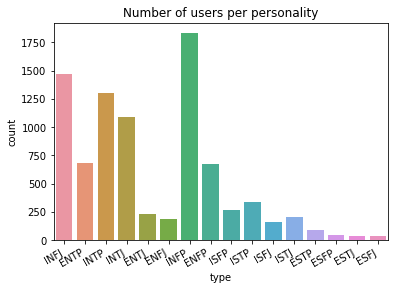

In [5]:
chart = sns.countplot(data.type)
plt.title("Number of users per personality")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [6]:
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
def translate_personality(personality):
    # transform mbti to binary vector
    
    return [b_Pers[l] for l in personality]

In [7]:
# We want to remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
  
unique_type_list = unique_type_list + [x.lower() for x in unique_type_list]
# Preprocess data
def pre_process_data(data, remove_stop_words=True, remove_mbti_profiles=True):

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 500 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments using regular expressions
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub('\|\|\|',"[SEP] ",temp)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp)
        temp = re.sub("(SEP )+","[SEP] ",temp) 
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")
        '''temp= "[CLS]" + temp
        temp = re.sub("(\[CLS\] *\[SEP\])","[CLS] ",temp)'''
        temp = re.sub("\[SEP\]+","| ",temp) 
        type_labelized = translate_personality(row[1].type)
        list_personality.append(type_labelized)
        list_posts.append(temp)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

In [8]:
list_posts, list_personality  = pre_process_data(data, remove_stop_words=True)

1 of 8675 rows
500 of 8675 rows
1000 of 8675 rows
1500 of 8675 rows
2000 of 8675 rows
2500 of 8675 rows
3000 of 8675 rows
3500 of 8675 rows
4000 of 8675 rows
4500 of 8675 rows
5000 of 8675 rows
5500 of 8675 rows
6000 of 8675 rows
6500 of 8675 rows
7000 of 8675 rows
7500 of 8675 rows
8000 of 8675 rows
8500 of 8675 rows
8675 of 8675 rows


In [9]:
X=list_posts
Y=list_personality
print(X[0])
print(Y[0])

 |   and  moments sportscenter not top ten plays pranks |  What has been the most life changing experience in your life |  On repeat for most of today |  May the PerC Experience immerse you |  The last thing my  friend posted on his facebook before committing suicide the next day Rest in peace |  Hello  Sorry to hear of your distress It s only natural for a relationship to not be perfection all the time in every moment of existence Try to figure the hard times as times of growth as |  Welcome and stuff |  Game Set Match |  Prozac wellbrutin at least thirty minutes of moving your legs and I don t mean moving them while sitting in your same desk chair weed in moderation maybe try edibles as a healthier alternative |  Basically come up with three items you ve determined that each type or whichever types you want to do would more than likely use given each types cognitive functions and whatnot when left by |  All things in moderation Sims is indeed a video game and a good one at that Note 

In [10]:
# importing the tokenizer and testing it
tokenizer = FullTokenizer(
  vocab_file="./dataset/bert/vocab.txt"
)
tokens=tokenizer.tokenize("I'm here to stay , hello nice to meet you sir")
tokens=["[CLS]"]+tokens+["[SEP]"]
print(tokens)
indices=tokenizer.convert_tokens_to_ids(tokens)
print(indices)

['[CLS]', 'i', "'", 'm', 'here', 'to', 'stay', ',', 'hello', 'nice', 'to', 'meet', 'you', 'sir', '[SEP]']
[101, 1045, 1005, 1049, 2182, 2000, 2994, 1010, 7592, 3835, 2000, 3113, 2017, 2909, 102]


In [11]:
# Tokenizing the features
def tokenize_features(X):
    X_tokenized=[]
    for i,entry in enumerate(X):
        if (i % 500 == 0 or i == 1 or i == len(X)):
            print("%s of %s rows" % (i, len(X)))
        temp=[]
        temp=tokenizer.tokenize(entry)
        temp = [w.replace('|', '[SEP]') for w in temp]
        if temp[0] == "[SEP]":
            temp.pop(0)
        temp.insert(0,"[CLS]")
        temp.append("[SEP]")
        X_tokenized.append(temp)
    return(X_tokenized)

X_tokenized=tokenize_features(X)

0 of 8675 rows
1 of 8675 rows
500 of 8675 rows
1000 of 8675 rows
1500 of 8675 rows
2000 of 8675 rows
2500 of 8675 rows
3000 of 8675 rows
3500 of 8675 rows
4000 of 8675 rows
4500 of 8675 rows
5000 of 8675 rows
5500 of 8675 rows
6000 of 8675 rows
6500 of 8675 rows
7000 of 8675 rows
7500 of 8675 rows
8000 of 8675 rows
8500 of 8675 rows


In [12]:
# indexing the tokens
def tokens_to_indices(tokens):
    result = []
    for element in tokens:
        indices =[]
        indices=tokenizer.convert_tokens_to_ids(element)
        result.append(indices)
    return result
X_indexed=tokens_to_indices(X_tokenized)
print(X_indexed[0])

[101, 1998, 5312, 2998, 13013, 2121, 2025, 2327, 2702, 3248, 26418, 2015, 102, 2054, 2038, 2042, 1996, 2087, 2166, 5278, 3325, 1999, 2115, 2166, 102, 2006, 9377, 2005, 2087, 1997, 2651, 102, 2089, 1996, 2566, 2278, 3325, 10047, 16862, 2063, 2017, 102, 1996, 2197, 2518, 2026, 2767, 6866, 2006, 2010, 9130, 2077, 16873, 5920, 1996, 2279, 2154, 2717, 1999, 3521, 102, 7592, 3374, 2000, 2963, 1997, 2115, 12893, 2009, 1055, 2069, 3019, 2005, 1037, 3276, 2000, 2025, 2022, 15401, 2035, 1996, 2051, 1999, 2296, 2617, 1997, 4598, 3046, 2000, 3275, 1996, 2524, 2335, 2004, 2335, 1997, 3930, 2004, 102, 6160, 1998, 4933, 102, 2208, 2275, 2674, 102, 4013, 4143, 2278, 2092, 19892, 21823, 2078, 2012, 2560, 4228, 2781, 1997, 3048, 2115, 3456, 1998, 1045, 2123, 1056, 2812, 3048, 2068, 2096, 3564, 1999, 2115, 2168, 4624, 3242, 17901, 1999, 5549, 8156, 2672, 3046, 21006, 2015, 2004, 1037, 2740, 3771, 4522, 102, 10468, 2272, 2039, 2007, 2093, 5167, 2017, 2310, 4340, 2008, 2169, 2828, 2030, 29221, 4127, 2017, 

In [13]:
# getting the longest indexed array
def max_post_words(posts):
    maxLen=0
    averageLen=0
    for post in posts:
        averageLen=averageLen+len(post)
        if maxLen < len(post):
            maxLen=len(post)
    averageLen=int(averageLen/len(posts))
    return maxLen,averageLen
maxLen,avgLen=max_post_words(X_indexed)
print(maxLen)
print(avgLen)

2132
1418


In [14]:
# adding padding 
def padding(indices):
    for i,element in enumerate(indices):
        pad=maxLen-len(element)
        l = [0] * pad
        indices[i]=indices[i] + l
    return(indices)
X=np.array(padding(X_indexed))
Y=(np.array(list_personality[:,0])).astype(np.float32)
#Y=(np.array(list_personality)).astype(np.float32)
# Not enough memory to train model with maxLen input size so i'll take the first 512
#X=X[:,:512]

In [15]:
def create_model():    
    with tf.io.gfile.GFile("./dataset/bert/bert_config.json", "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
    input_ids = keras.layers.Input(shape=(maxLen,), dtype='int16', name="input_ids")
    bert_output = bert(input_ids)
    print("bert shape", bert_output.shape)
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    X1 = keras.layers.Dense(units=1,name="I/E_classifier", activation="sigmoid")(logits)
    '''X2 = keras.layers.Dense(units=1,name="N/S_classifier", activation="sigmoid")(logits)
    X3 = keras.layers.Dense(units=1,name="F/T_classifier", activation="sigmoid")(logits)
    X4 = keras.layers.Dense(units=1,name="J/P_classifier", activation="sigmoid")(logits)
    finalOutput=keras.layers.concatenate(
    inputs=[X1,X2,X3,X4],
    name='final_output')'''
    model = keras.Model(inputs=input_ids, outputs=X1)
    model.build(input_shape=(None, maxLen))
    load_stock_weights(bert, "./dataset/bert/bert_model.ckpt")
    model.layers[1].trainable = False
    return model

In [16]:
bertModel = create_model()
bertModel.summary()

bert shape (None, 2132, 768)
loader: Skipping weight:[bert/embeddings/position_embeddings/embeddings:0] as the weight shape:[(2132, 768)] is not compatible with the checkpoint:[bert/embeddings/position_embeddings] shape:(512, 768)
Done loading 195 BERT weights from: ./dataset/bert/bert_model.ckpt into <bert.model.BertModelLayer object at 0x0000013F1FA48748> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [1]
Unused weights from checkpoint: 
	bert/embeddings/position_embeddings
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)           

In [17]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
def multi_loss(y_true,y_pred):
    return K.mean(K.sum(K.binary_crossentropy(y_true,y_pred)))

In [19]:
# Defining hyperparameters
EPOCHS = 5
BS = 32
LR=1e-5
# Compiling and training
bertModel.compile(
  optimizer=keras.optimizers.Adam(LR),
  loss="binary_crossentropy",
  metrics=["accuracy",f1]
)
print(X.shape)
print(Y.shape)
(X_train, X_temp, Y_train, Y_temp) = train_test_split(X,Y,test_size=0.2, random_state=42)
(X_valid, X_test, Y_valid, Y_test) = train_test_split(X_temp,Y_temp,test_size=0.5, random_state=42)
history = bertModel.fit(
  X_train, 
  Y_train,
  validation_data=(X_valid,Y_valid),
  batch_size=BS,
  shuffle=True,
  epochs=EPOCHS,
  verbose=1
)

(8675, 2132)
(8675,)
Train on 6940 samples, validate on 867 samples
Epoch 1/5
  32/6940 [..............................] - ETA: 1:25:00

ResourceExhaustedError:  OOM when allocating tensor with shape[32,12,2132,2132] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/bert/encoder/layer_0/attention/self/MatMul (defined at D:\Users\Shintaki\Anaconda3\lib\site-packages\bert\attention.py:112) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_27301]

Errors may have originated from an input operation.
Input Source operations connected to node model/bert/encoder/layer_0/attention/self/MatMul:
 model/bert/encoder/layer_0/attention/self/transpose (defined at D:\Users\Shintaki\Anaconda3\lib\site-packages\bert\attention.py:103)

Function call stack:
distributed_function


In [ ]:
test_loss, test_acc,test_f1 = bertModel.evaluate(X_test,Y_test)
print("Accuracy : ",test_acc)
print("F1 Score :",test_f1)
print("Loss :",test_loss)
Yhat=bertModel.predict(X_test)
correct=0
correctlabels=[0,0,0,0]
for i,prediction in enumerate(Yhat):
    for j,value in enumerate(prediction):
        if (value<0.5):
            prediction[j]=0
        else:
            prediction[j]=1
        if(prediction[j]==Y_test[i][j]):
            correctlabels[j]+=1
    if (np.array_equal(prediction,Y_test[i])):
        correct+=1
    print("Prediction :",prediction," Actual Value :",Y_test[i] )
print("Total accuracy : ",correct/len(X_test))
print("I/E accuracy : ",correctlabels[0]/len(X_test))
print("N/S accuracy : ",correctlabels[1]/len(X_test))
print("F/T accuracy : ",correctlabels[2]/len(X_test))
print("J/P accuracy : ",correctlabels[3]/len(X_test))
print("Binary accuracy :",np.sum(correctlabels)/(4*len(X_test)))